**Project:** Sentiment Analysis of [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

**Author:** [Giuseppe Muschetta](https://github.com/peppe212)

**Python version:** 3.8

### SUPPORT VECTOR CLASSIFIER
**Model:** [sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [1]:
# Sopprimiamo i fastidiosissimi warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             roc_curve, 
                             auc, 
                             accuracy_score,
                             precision_recall_curve,
                             average_precision_score)
from pathlib import Path
import joblib

#### IMPOSTAZIONE DEI PATH

In [3]:
# Caricamento del Dataset già pulito
DATASET_PATH = Path() / "Dataset/cleaned_reviews.csv"
df = pd.read_csv(DATASET_PATH)
if df.isna().any().any():
    df.fillna("", inplace=True)

# Impostazione path per il salvataggio immagini
IMAGES_PATH = Path() / "Images" / "LinearSVC"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_my_image(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return


# Gestione salvataggio e caricamento del modello di LinearSVC
MODEL_PATH = Path() / "Saved_models" / "LinearSVC"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Salva il modello su un file di estensione default.tf
def save_my_model(model, model_name='LinearSVC', model_extension="joblib"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    try:
        # salva il modello utilizzando la libreria joblib
        joblib.dump(model, path)
        print(f"Modello salvato correttamente in: {path}")
    except Exception as e:
        print(f"Si è verificato un errore durante il salvataggio del modello: {e}")
        raise FileNotFoundError
#end_function

# Carica il modello dal file con estensione a default.tf
def load_my_model(model_name='LinearSVC', model_extension="joblib"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    if path.exists():
        try:
            model = joblib.load(path)
            print(f"Modello caricato correttamente da: {path}")
            return model
        except Exception as e:
            print(f"Si è verificato un errore durante il caricamento del modello: {e}")
            raise
    else:
        error_msg = f"Il file del modello non esiste: {path}"
        print(error_msg)
        raise FileNotFoundError(error_msg)
#end_function


### Preparing data

In [4]:
# Split dei dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['sentiment'])

# Per visualizzare le proporzioni
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))

print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))


Size of Training Data  131259
Size of Test Data  32815
Distribution of classes in Training Data :
Positive Sentiment  50.00038092626029
Negative Sentiment  49.9996190737397
Distribution of classes in Testing Data :
Positive Sentiment  49.99847630656712
Negative Sentiment  50.00152369343288


### Training and evaluation of the LinearSVC model

In [5]:
# Feature Extraction and Weighting
tfidf = TfidfVectorizer(stop_words='english')
# Feature Selection
selkbest = SelectKBest(score_func=chi2)

# ISTANZIO IL MODELLO di classificazione LinearSVC ed effettuo il training
# tutti gli iper-parametri del modello verranno testati con la GridSearchCV
# che al suo interno effettuerà anche una Cross Validation a 5 fold e
# il set di validazione (importantissimo) verrà automaticamente creato dal set di training
# tutti gli iper-parametri sono settati nella griglia
model = LinearSVC(random_state=42) 

# TUNING IPER-PARAMETRI
# la vera griglia è su per ora faccio il training su questa semplificata 
# per finire l'elaborazione in tempi umani
param_grid = [{
    # TUNING tfidf
    # minimum document frequency:
    'tfidf__min_df': [10], # [1, 2, 5, 10, 15]
    # max document frequency:
    'tfidf__max_df': [0.5], # [0.5, 0.75, 0.95]
    # intervallo di engrammi da considerare:
    'tfidf__ngram_range': [(1, 2)], # [(1, 1), (1, 2), (1, 3), (1, 6)]
    # da più peso ai termini meno frequenti, un must per la sentiment analysis
    'tfidf__use_idf': [True], # [True, False],
    # idem come prima
    'tfidf__smooth_idf': [True], # [True, False]
    # TUNING selkbest
    # Variazione nel numero di feature selezionate
    'selkbest__k': [20000], # [5000, 7500, 10000, 15000, 20000],
    # TUNING model  
    # parametro di regolarizzazione del margine
    # un valore troppo alto può poetare a overfitting
    'model__C': [1], # [0.1, 0.5, 1, 5, 10]
    # funzione di loss, squared hinge è la più efficace con LinearSVC
    'model__loss': ['squared_hinge'], # ['hinge', 'squared_hinge']
    # se il dataset è piccolo va bene 1000, vediamo con 5000 anche
    'model__max_iter': [1000], # [1000, 5000, 10000]
    # L2 è la norma usata per la penalizzazione
    'model__penalty': ['l2'], # ['l1', 'l2']
    # il problema viene risolto in forma duale e non primale
    'model__dual': [True], # [True, False]
    # tolleranza per il criterio di stop
    'model__tol': [1e-5] # [1e-4, 1e-3, 1e-2, 1e-1]
}]


# Imposto una pipeline per automatizzare il tutto
estimator = Pipeline([('tfidf', tfidf), 
                      ('selkbest', selkbest),  
                      ('model', model)])

# Istanzio la GridSearchCV
grid_search_cv = GridSearchCV(estimator=estimator,
                              param_grid=param_grid,
                              cv=5,
                              verbose=1,
                              n_jobs=-1) # importante per il parallelismo

# AVVIO DEL TRAINING
grid_search_cv.fit(X_train, y_train)

# Cerchiamo di capire quali sono i migliori iper-parametri
best_params = grid_search_cv.best_params_
print("Best iper-parameters identified by grid search are: ", best_params)

best_result = grid_search_cv.best_score_
print("Best result identified by grid search are: ", best_result)

# In questa variabile conserviamo il best model
best_model = grid_search_cv.best_estimator_

# MODEL EVALUATION:
y_pred = best_model.predict(X_test)
print("Accuracy - ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#BEST PARAMETERES:
# 'model__C': 1, 
# 'model__dual': True, 
# 'model__loss': 'squared_hinge', 
# 'model__max_iter': 1000, 
# 'model__penalty': 'l2', 
# 'model__tol': 1e-05, 
# 'selkbest__k': 20000, 
# 'tfidf__max_df': 0.5, 
# 'tfidf__min_df': 10, 
# 'tfidf__ngram_range': (1, 2), 
# 'tfidf__smooth_idf': True, 
# 'tfidf__use_idf': True

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best iper-parameters identified by grid search are:  {'model__C': 1, 'model__dual': True, 'model__loss': 'squared_hinge', 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__tol': 1e-05, 'selkbest__k': 20000, 'tfidf__max_df': 0.5, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}
Best result identified by grid search are:  0.9136363901779602
Accuracy -  0.9135456346183148
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     16408
           1       0.91      0.91      0.91     16407

    accuracy                           0.91     32815
   macro avg       0.91      0.91      0.91     32815
weighted avg       0.91      0.91      0.91     32815

Confusion Matrix:
 [[14972  1436]
 [ 1401 15006]]


#### Saving trained model

In [6]:
# Salvataggio del modello su file.joblib
save_my_model(best_model)

Modello salvato correttamente in: Saved_models/LinearSVC/LinearSVC.joblib


#### Loading trained model

In [7]:
# Carico il modello da file.joblib
model = load_my_model()

Modello caricato correttamente da: Saved_models/LinearSVC/LinearSVC.joblib


### CONFUSION MATRIX AND ROC AND AUC CURVES

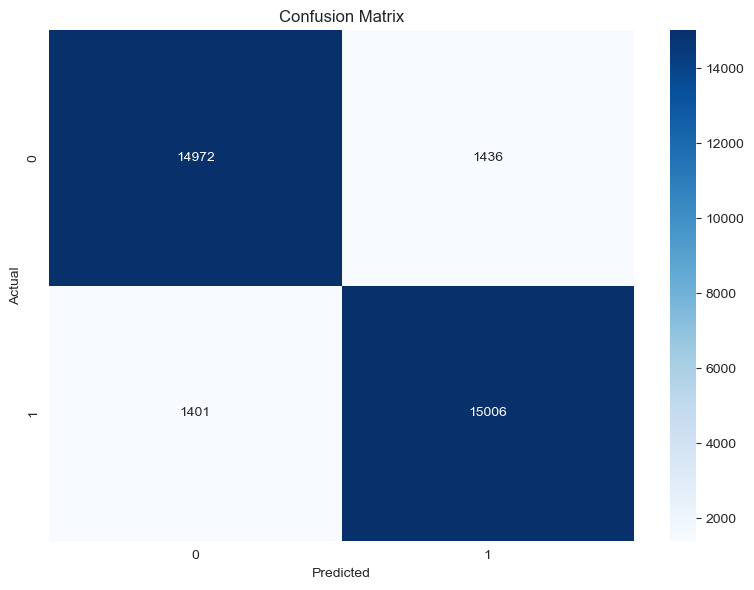

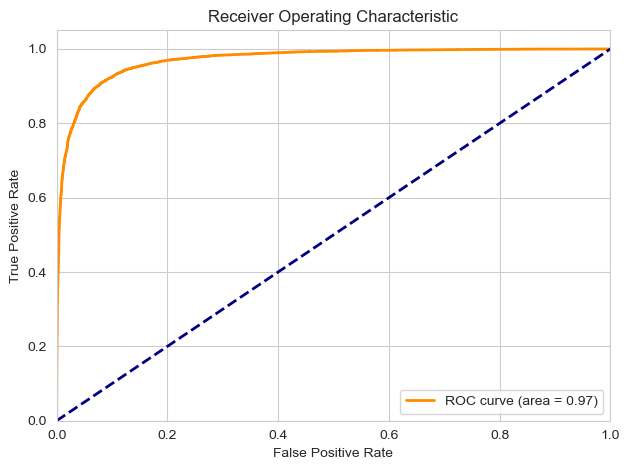

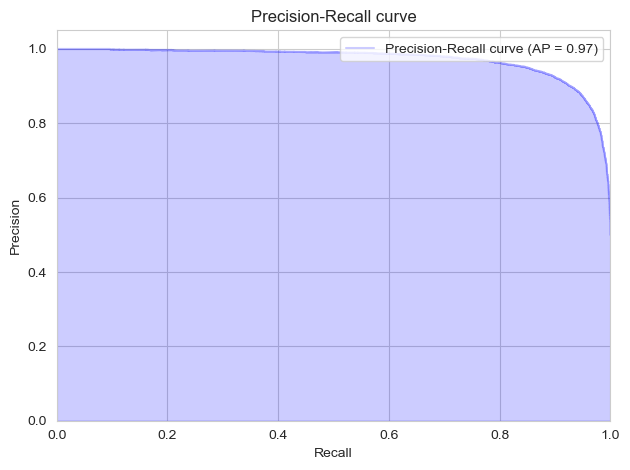

In [8]:
# Visualizzazione delle metriche per valutare la performance del modello
y_pred = model.predict(X_test)
y_scores = model.decision_function(X_test)  # Ottiene i punteggi di decisione

# Calcolo e visualizzazione con heatmap della matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
save_my_image("confusion_matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
save_my_image("roc_auc")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)
plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
save_my_image("precision_recall_curve")
plt.show()

### Predicting sentiment from a review

In [9]:
import clean_text_script

# Predico il sentiment di una recensione
def predict_sentiment(model, review):
    """
    Classifica una nuova recensione come positiva o negativa.

    @Args:
    review (str): La recensione da classificare.
    model (Pipeline): Il modello di classificazione trainato.

    @Returns:
    str: "positiva" se la recensione è classificata positiva, "negativa" altrimenti.
    """
    prediction = model.predict([review])
    if prediction[0] == 1:
        return 'Positiva'
    else:
        return 'Negativa'


# INSERISCI IL TESTO DELLA RECENSIONE PER PREDIRNE IL SENTIMENT
review_text = "Excellent value I love the portability so I can take this on the run in my purse or backpack. Flavor is really good. My only disappointment was the actual size of each bar. Otherwise I thought it was really tasty and would love to buy again."

cleaned_text = clean_text_script.clean_text(review_text)
sentiment = predict_sentiment(model, cleaned_text)
print(f"Il sentiment della recensione è: {sentiment}")

Il sentiment della recensione è: Positiva
